<div style = "text-align:center">
    <h1>Housing Forecast</h1>
</div>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
test.head()

,id,zipcode,city,state,dateSold,bathrooms,bedrooms,livingArea,homeType,homeStatus,lotArea,lotUnit,address
0,22805,19970.0,Ocean View,DE,1.641283e+12,4.0,5.0,4100.0,SINGLE_FAMILY,RECENTLY_SOLD,10454.40,sqft,"37150 Lord Baltimore Ln, Ocean View, DE 19970"
1,18392,27704.0,Durham,NC,1.641542e+12,3.0,4.0,2055.0,SINGLE_FAMILY,RECENTLY_SOLD,0.29,acres,"2011 Woodview Dr, Durham, NC 27704"
2,15215,20733.0,Churchton,MD,1.641542e+12,2.0,3.0,1530.0,SINGLE_FAMILY,RECENTLY_SOLD,4791.60,sqft,"1109 Wildwood Ln, Churchton, MD 20733"
3,20235,33064.0,Pompano Beach,FL,1.641370e+12,1.0,3.0,744.0,SINGLE_FAMILY,RECENTLY_SOLD,6120.00,sqft,"3130 NE 12th Ave, Pompano Beach, FL 33064"
4,13810,6239.0,Killingly,CT,1.640851e+12,3.0,6.0,4166.0,SINGLE_FAMILY,RECENTLY_SOLD,37.00,sqft,"235 Ross Rd, Killingly, CT 06239"


In [4]:
train.columns

Index(['id', 'zipcode', 'city', 'state', 'dateSold', 'bathrooms', 'bedrooms',
       'livingArea', 'homeType', 'homeStatus', 'lotArea', 'lotUnit', 'address',
       'price'],
      dtype='object')

Playing with Functions.

In [6]:
#Testing recursion
#Should return the nth fibonacci number (1, 1, 2, 3, 5, 8, 13, etc)
def fibonacci(n):
    if n == 1 or n == 0:
        return 1
    else:
        return fibonacci(n - 1) + fibonacci(n - 2)


In [9]:
fibonacci(20)

10946

Playing with some plotting.

In [15]:
#Playing with plotting

x = np.random.normal(size=100)
y = np.random.normal(size=100)

xp = np.random.normal(loc=2, scale=1.5, size=100)
yp = np.random.normal(loc=2, size=100)

(array([ 1.,  3., 11., 15., 20., 23., 11.,  9.,  5.,  2.]),
 array([-2.70137457, -2.14594308, -1.5905116 , -1.03508011, -0.47964863,
         0.07578285,  0.63121434,  1.18664582,  1.74207731,  2.29750879,
         2.85294028]),
 <BarContainer object of 10 artists>)

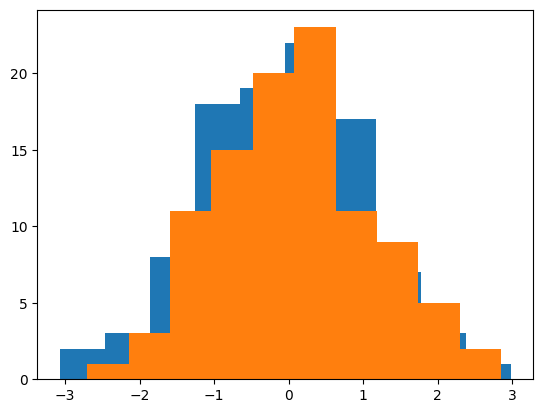

In [13]:
plt.hist(x)
plt.hist(y)

Text(0.5, 0, 'X axis')

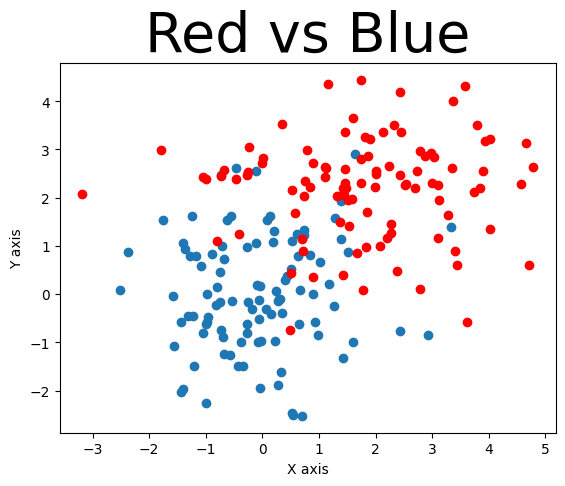

In [23]:
plt.scatter(x,y)
plt.scatter(xp, yp, c= 'red')
plt.title('Red vs Blue', fontdict={'size':40})
plt.ylabel('Y axis')
plt.xlabel('X axis')